In [6]:
# Get initial segmentation
import numpy as np
from utils.base_classes import Points

from classes.SAMMed2DClass import SAMMed2DInferer
import utils.analysis as anUt
import utils.prompt as prUt
from utils.image import read_im_gt
import utils.interactivity as inter

# Obtain model, image, gt
device = 'cuda'
sammed2d_checkpoint_path = "/home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth"
sammed2d_inferer = SAMMed2DInferer(sammed2d_checkpoint_path, device)

img_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_2img/imagesTr/BDMAP_00000001_0000.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_2img/labelsTr/BDMAP_00000001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 3)


True
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth


In [8]:

# # Obtain initial segmentation: Point propagation

seed = 11121
n_clicks = 5

# Get seed prompt and bounds
seed_point = prUt.get_seed_point(gt, n_clicks, seed)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation, intial_prompt = prUt.point_propagation(sammed2d_inferer, img, seed_point, slices_to_infer, seed, n_clicks)
print(anUt.compute_dice(gt,segmentation))


Propagating up: 100%|██████████| 22/22 [00:00<00:00, 68.29it/s]


0.8177772392806715


In [9]:
# Iteratively improve from line interpolation
## Generate initial segmentation
# seed = 11121
# seed = None
# n_slices = 5
# interpolation = 'linear'
# intial_prompt = prUt.line_interpolation(gt, n_slices, interpolation)

# segmentation = sammed2d_inferer.predict(img, point_prompt)

# Improve
condition = 'dof'
dof_bound = 90
dice_scores, dof, segmentations, prompts = inter.iterate_2d(sammed2d_inferer, img, gt, segmentation, intial_prompt, 
                                                            scribble_length= 1, contour_distance = 3, disk_size_range = (0,3),
                                                                        init_dof = 5, dof_bound = dof_bound, seed = seed, detailed = True, pass_prev_prompts=True, )


0.8241806974971224
0.8247004406164643
0.8247004406164643
0.9176323581343547
0.9216147620448133
0.9226636443388567
0.9250273959226187
0.9264414167160318
0.9265370901817549


Error in callback <function _draw_all_if_interactive at 0x7f80253cf060> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

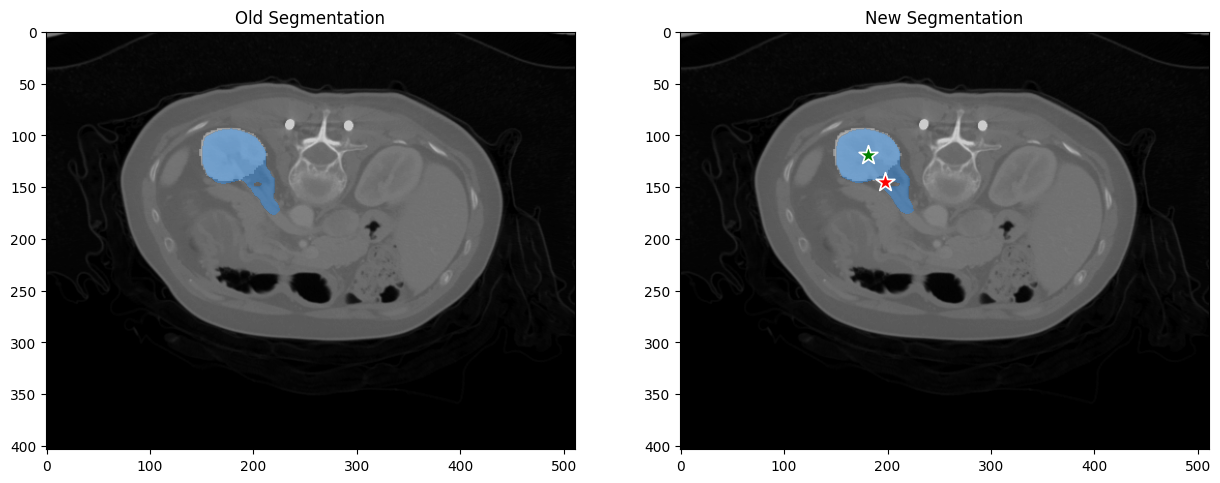

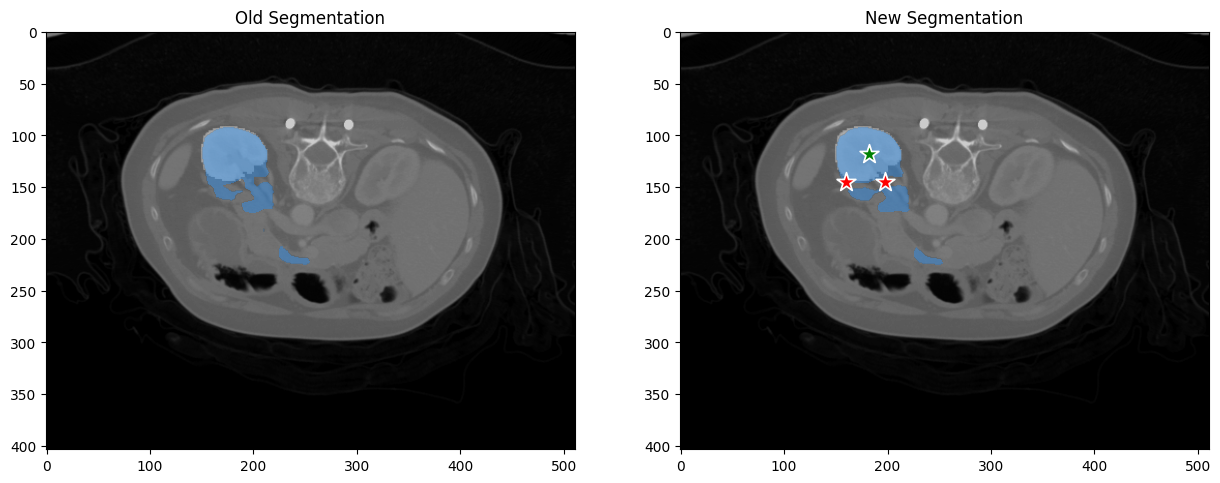

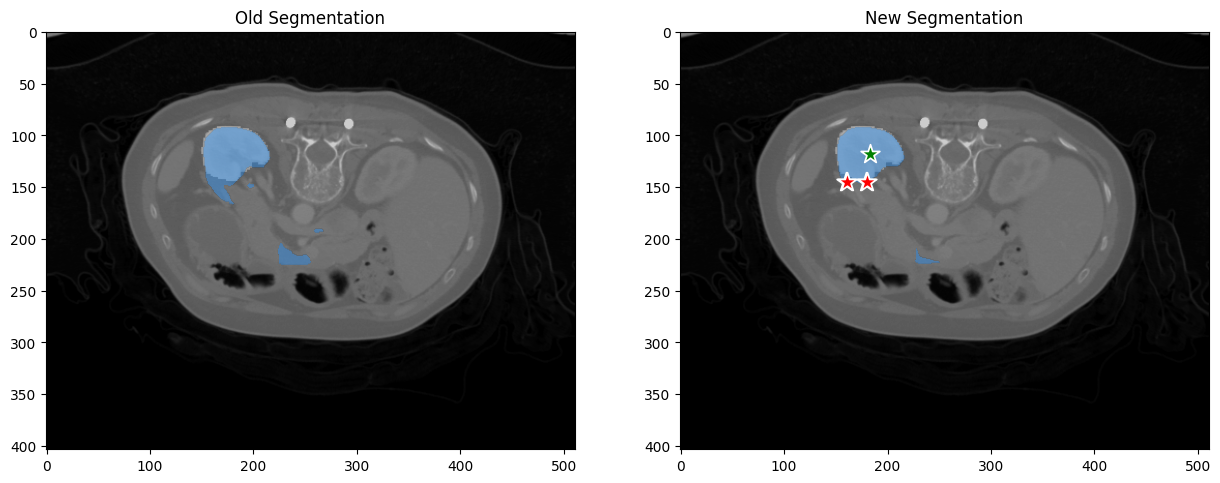

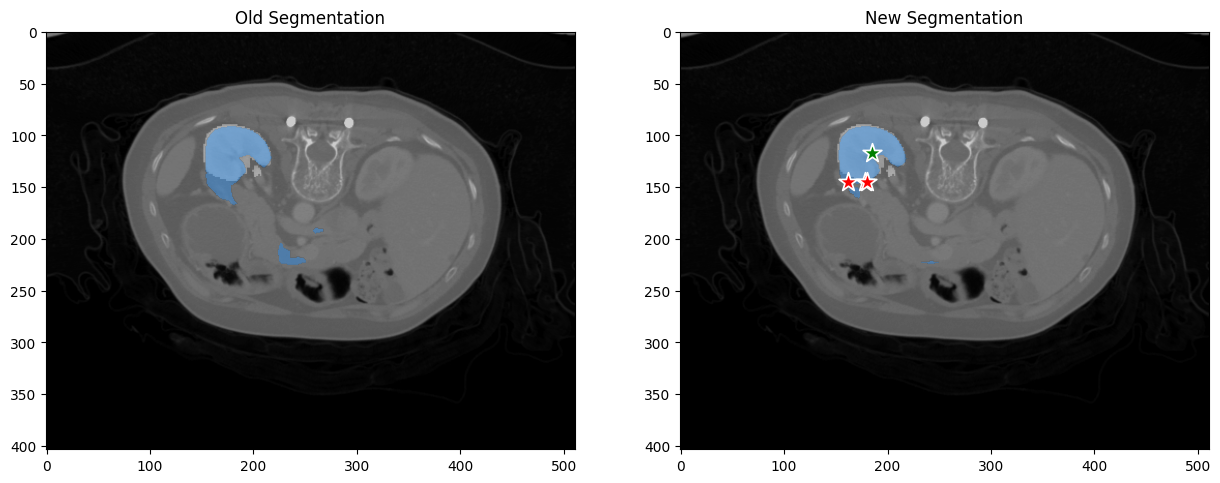

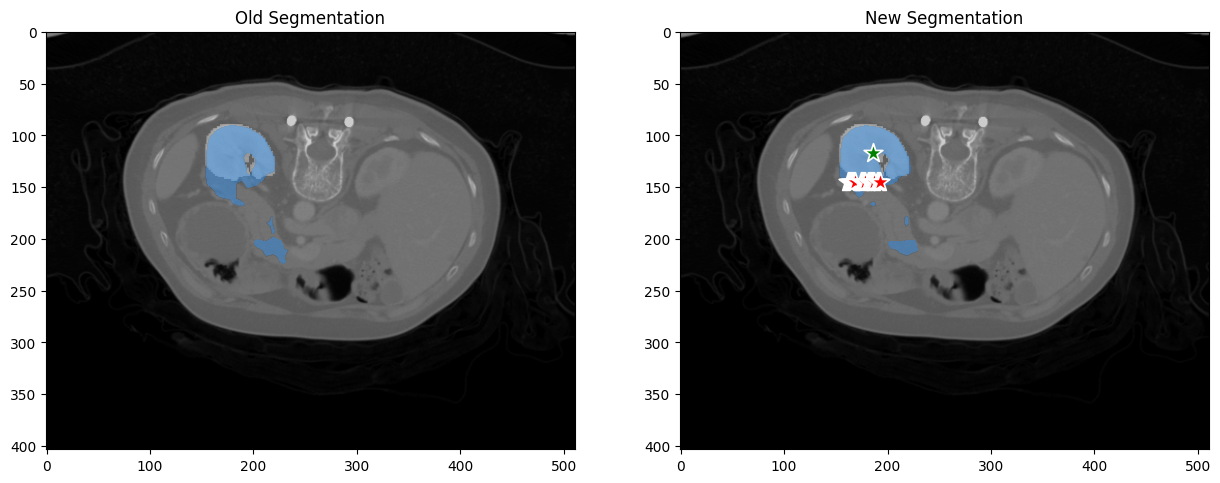

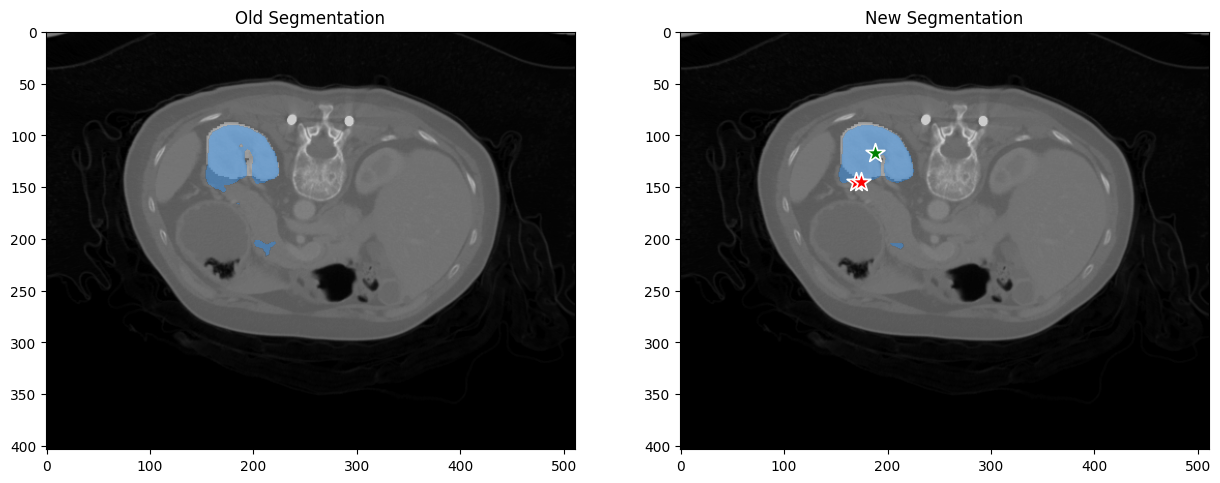

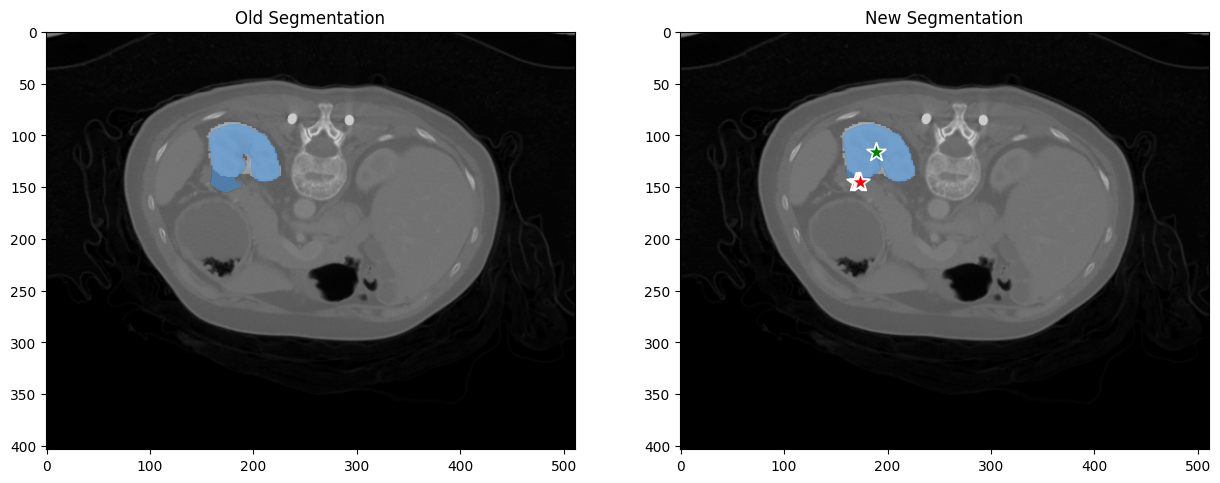

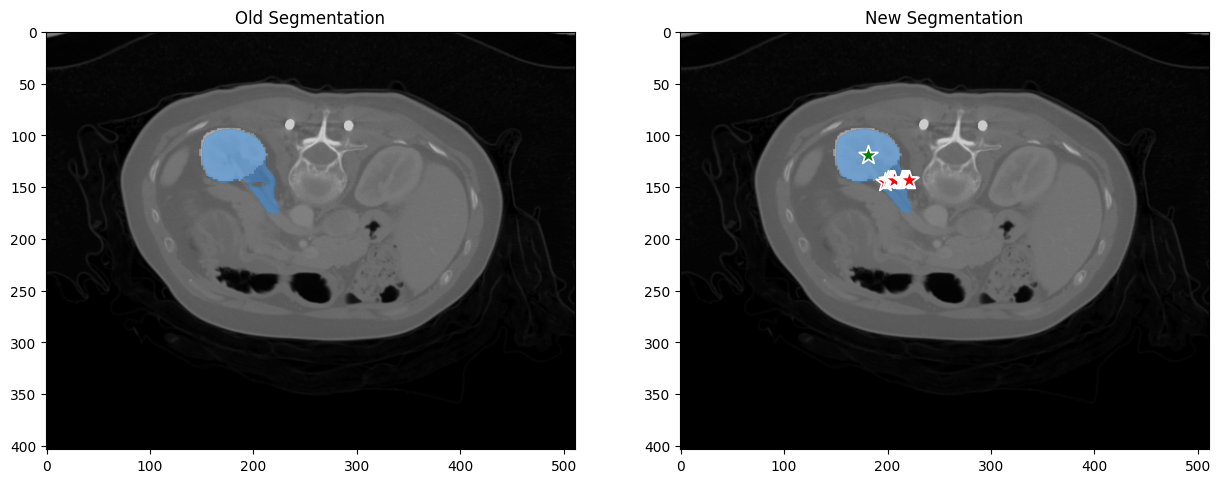

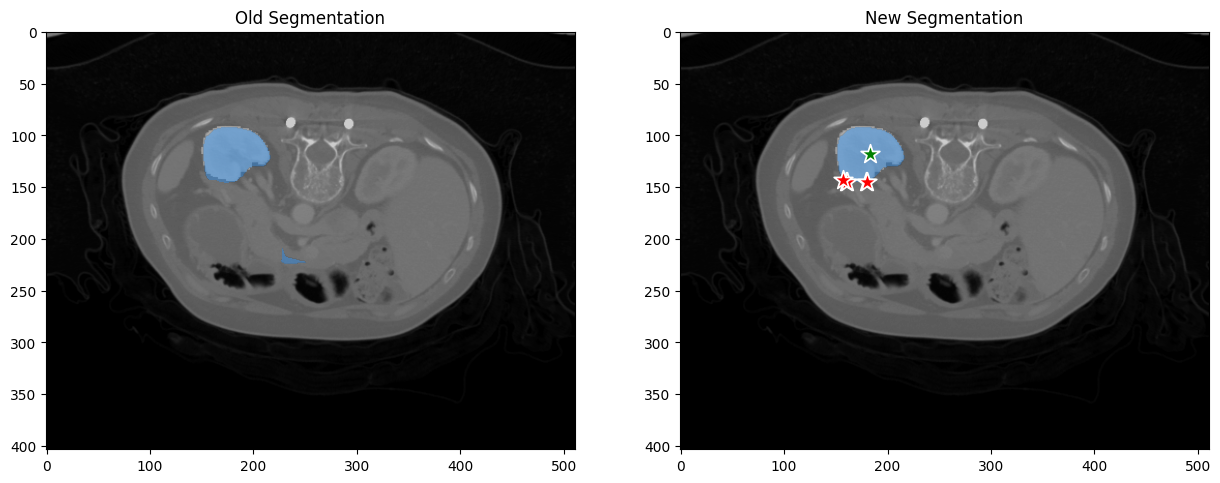

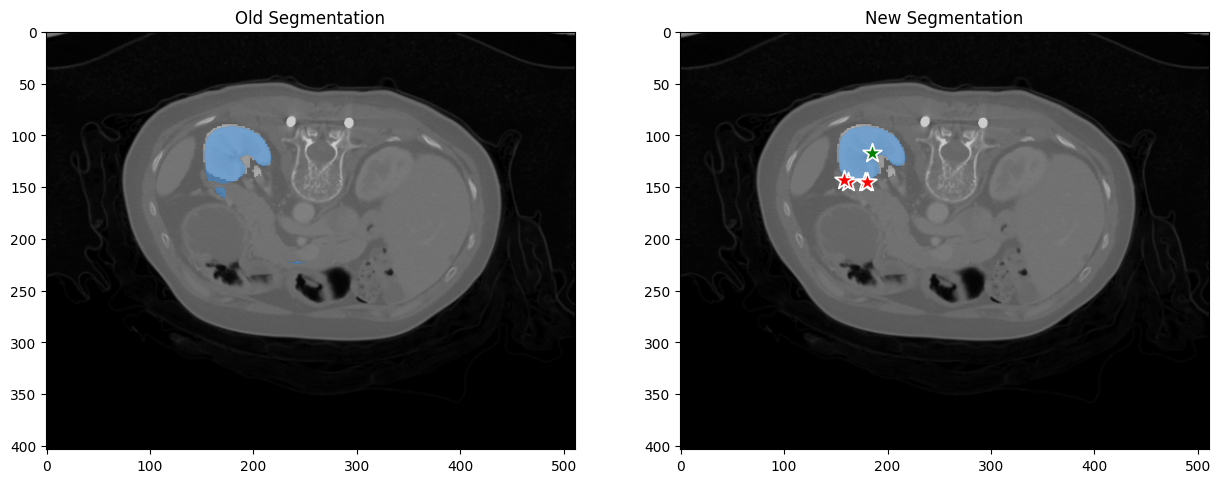

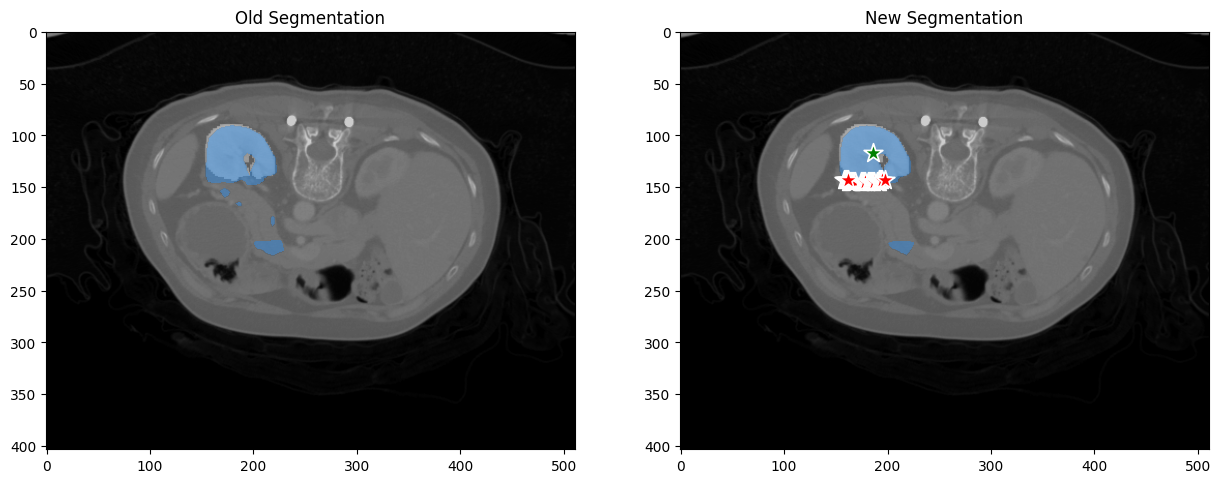

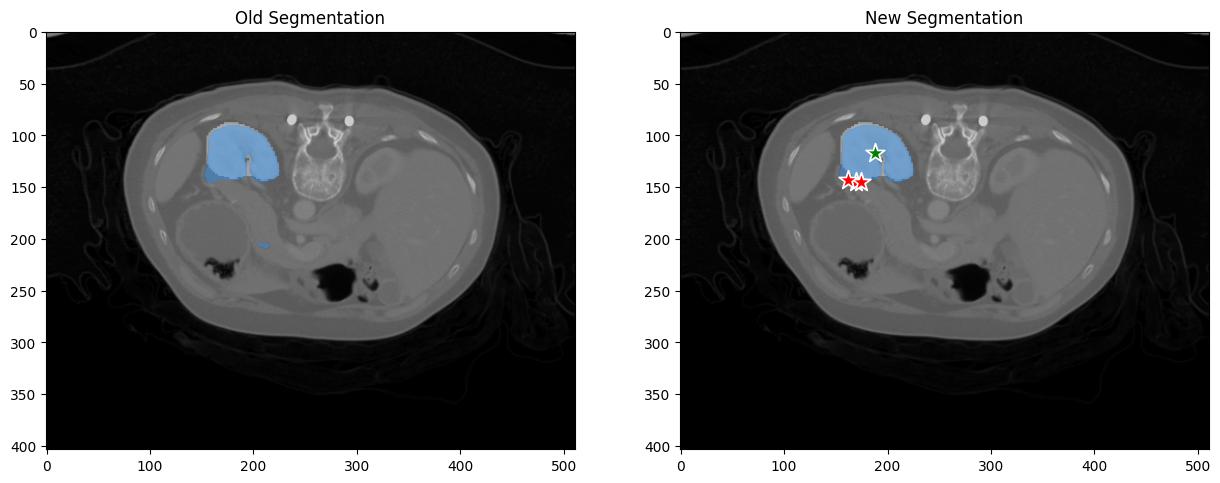

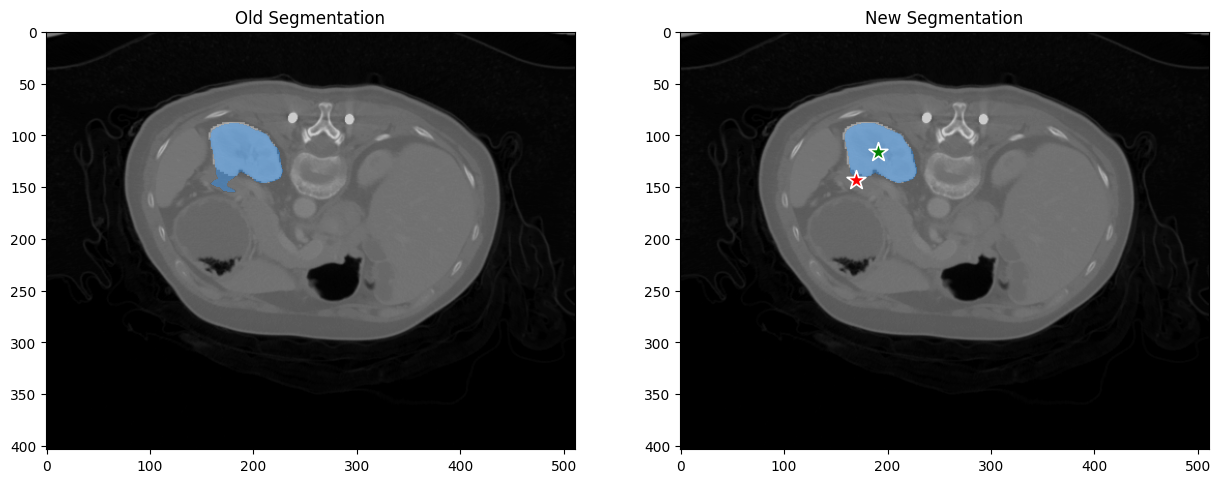

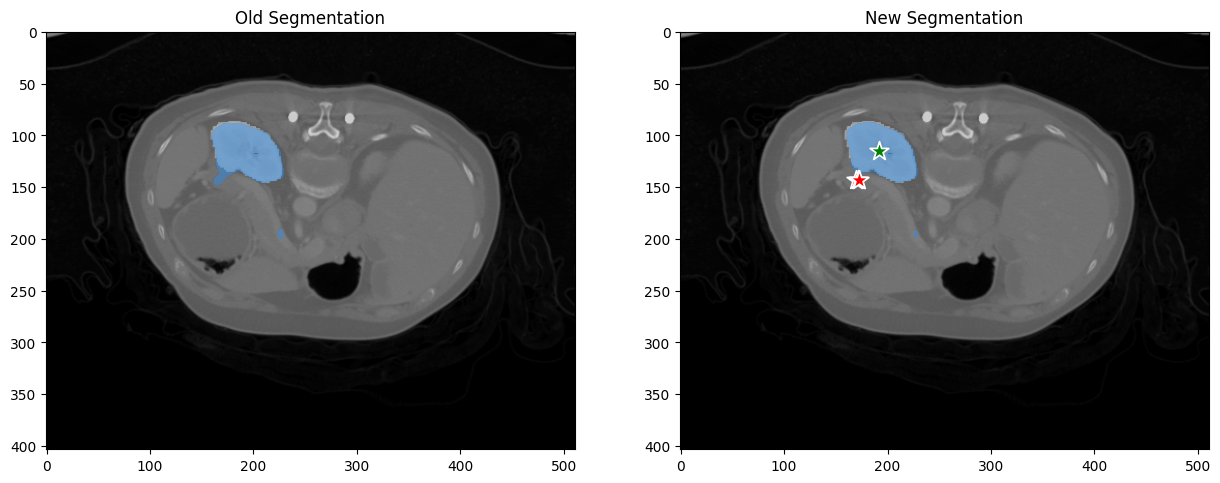

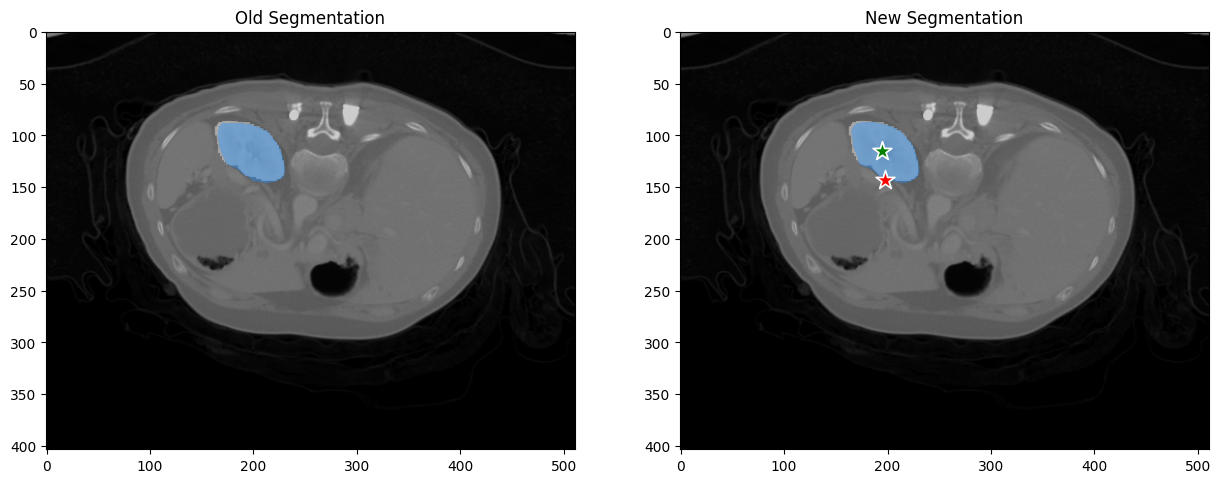

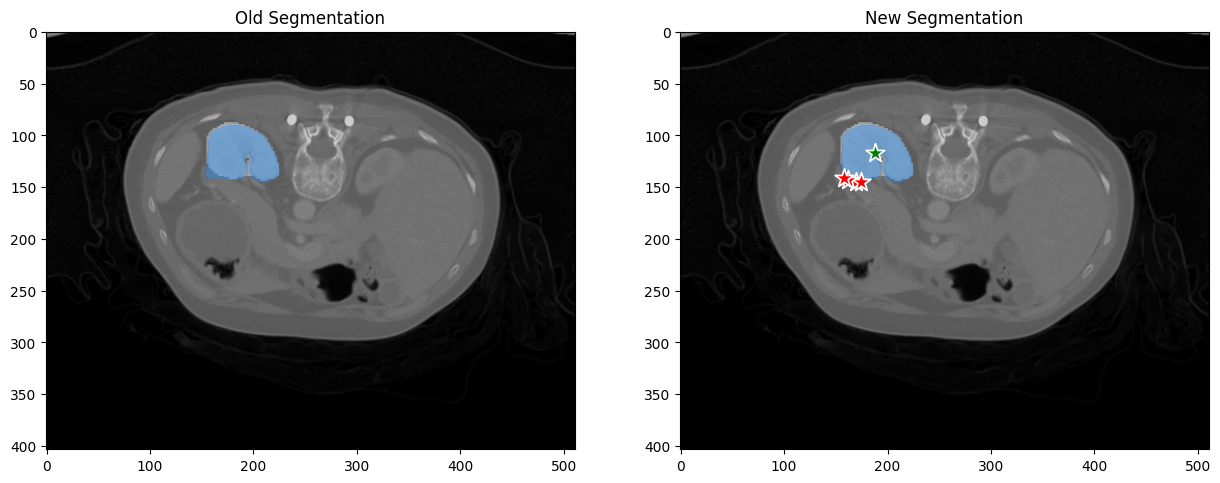

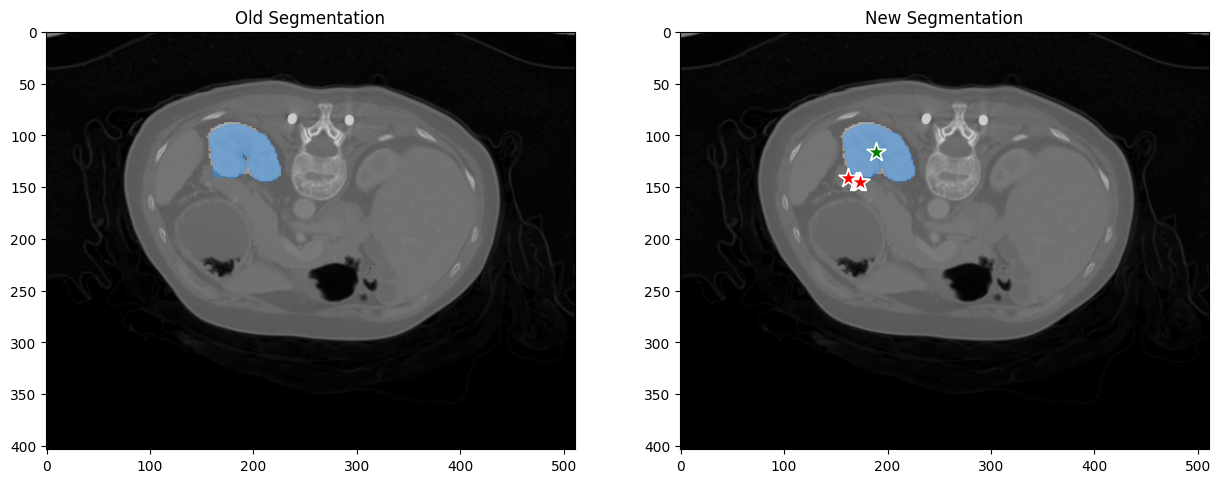

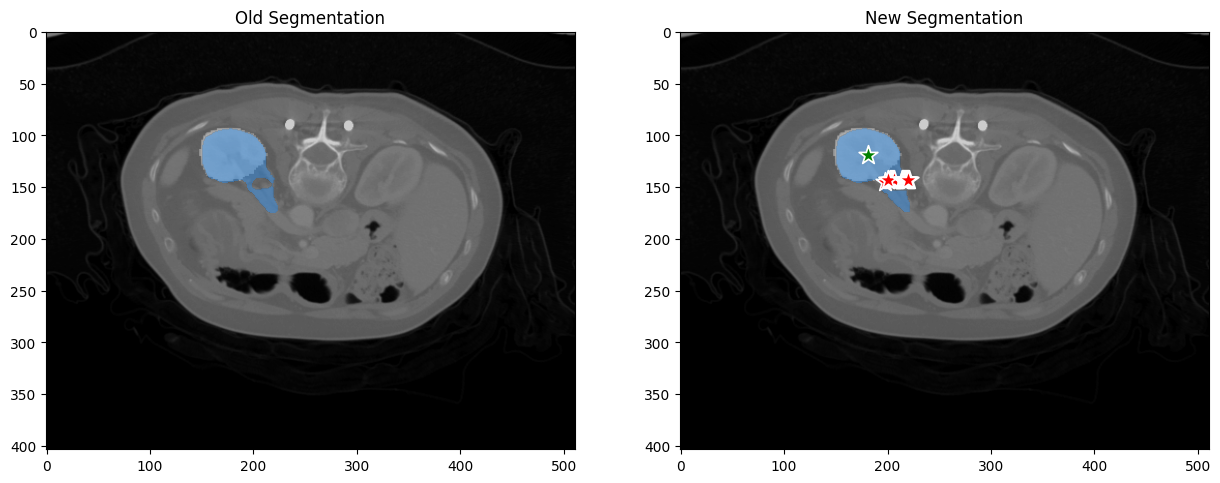

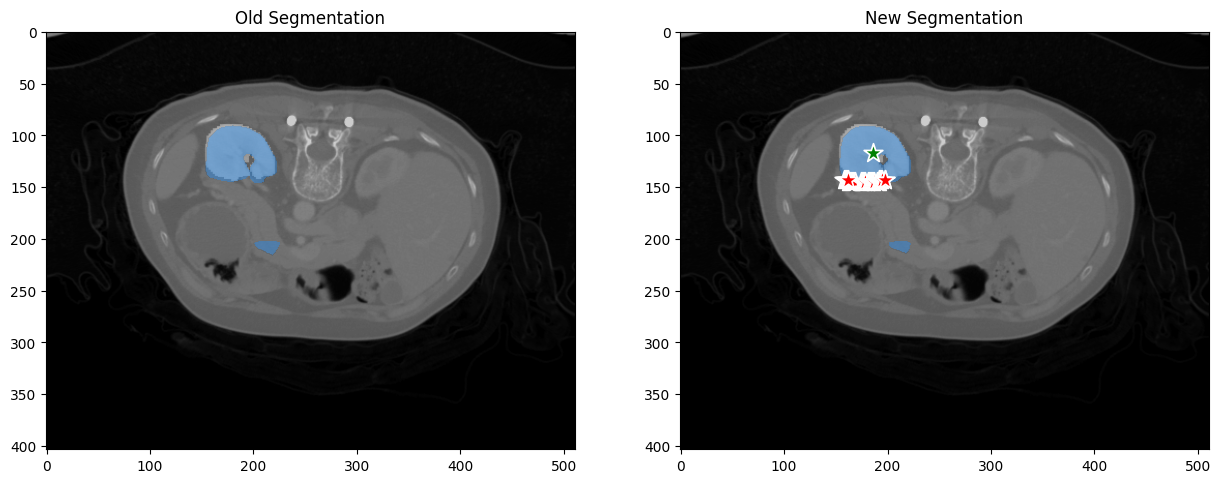

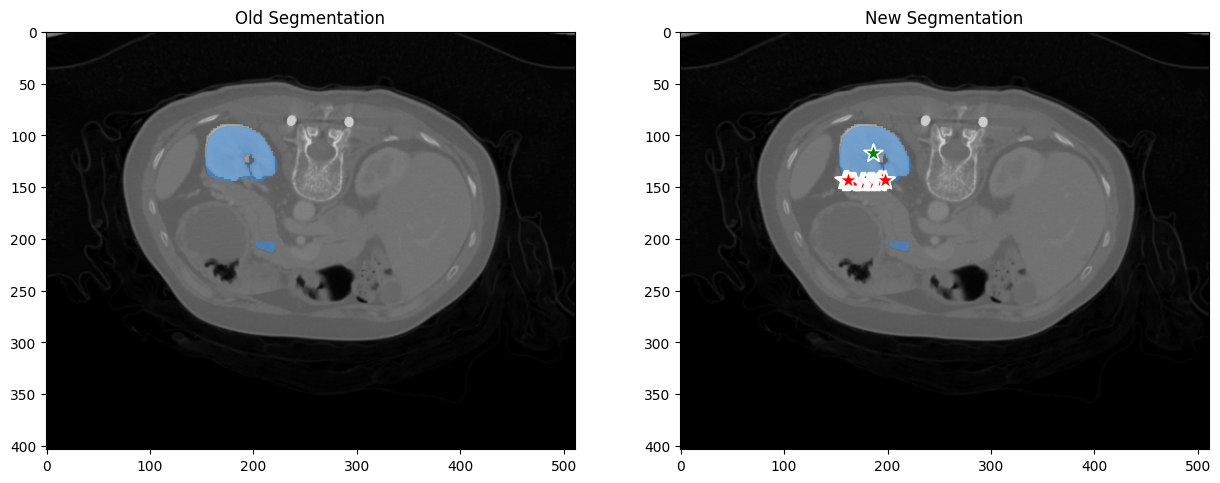

In [5]:
# # Analyse interaction code
# import matplotlib.pyplot as plt

# improve_slices = [np.unique(p.coords[:,0]) for p in prompts[1:]]

# for i, slice_idxs in enumerate(improve_slices):
#     old_seg, new_seg = segmentations[i], segmentations[i+1]
#     coords, labels = prompts[i+1].coords, prompts[i+1].labels
#     for slice_idx in slice_idxs:
#         dice_improve = anUt.compute_dice(gt, segmentation)

#         img_2d = img[slice_idx, ...]
#         gt_2d = gt[slice_idx, ...]
#         old_seg_2d = old_seg[slice_idx, ...]
#         new_seg_2d = new_seg[slice_idx, ...]
        
#         # Visualise
#         fig, ax = plt.subplots(1, 2, figsize=(15, 8))

#         ## Show image
#         img_2d = (img_2d-img_2d.min())/(img_2d.max()-img_2d.min())
#         ax[0].imshow(img_2d, cmap = 'gray')
#         ax[1].imshow(img_2d, cmap = 'gray')

#         ## Show gt
#         ax[0].imshow(gt_2d, alpha = 0.2, cmap = 'gray')
#         ax[1].imshow(gt_2d, alpha = 0.2, cmap = 'gray')

#         ## Show seg
#         color = np.array([30/255, 144/255, 255/255, 0.4])
#         h, w = old_seg_2d.shape[-2:]
#         old_seg_2d = old_seg_2d.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         ax[0].imshow(old_seg_2d)

#         new_seg_2d = new_seg_2d.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         ax[1].imshow(new_seg_2d)

#         ## Show prompts
#         coords_sub = coords[coords[:,0] == slice_idx, 1:] # Skip z coordinate
#         labels_sub = labels[coords[:,0] == slice_idx]

#         pos_points = coords_sub[labels_sub==1]
#         neg_points = coords_sub[labels_sub==0]
#         ax[1].scatter(pos_points[:, 1], pos_points[:, 0], color='green', marker='*', s=200, edgecolor='white', linewidth=1.25)
#         ax[1].scatter(neg_points[:, 1], neg_points[:, 0], color='red', marker='*', s=200, edgecolor='white', linewidth=1.25)
            
#         ax[0].set_title("Old Segmentation")
#         ax[1].set_title("New Segmentation")



Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 45/45 [00:00<00:00, 144.47it/s]
/home/t722s/Desktop/UniversalModels/Project/UniversalInterface/utils/interactivity_unstable.py:39: UserWarning:  All false positives not on contour: generating fg instead.
  warnings.warn(' All false positives not on contour: generating fg instead.')


0.9105639002628195
0.918920609763727
0.9217570529553623
0.9221284234656227
0.9244396866128262
Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00, 131.97it/s]


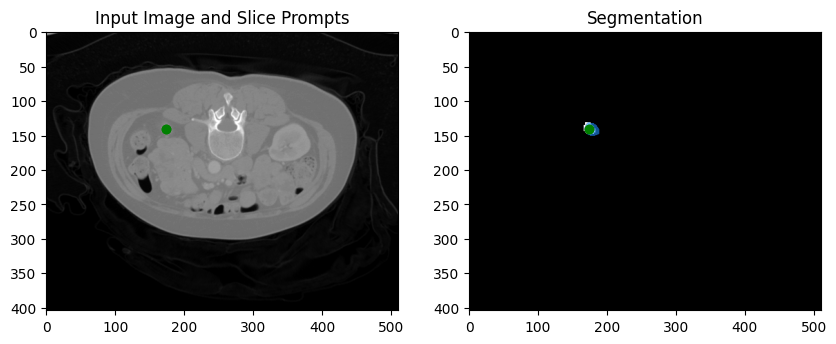

Dice change: -0.08436151113487911


In [6]:
import torch.nn.functional as F
import torch

# Generate segmentation to iterate on
seed = None
n_slices = 5
interpolation = 'linear'
point_prompt = prUt.line_interpolation(gt, n_slices, interpolation)

seg = sammed2d_inferer.predict(img, point_prompt)

# Iterate to get prompts
condition = 'dof'
dof_bound = 60
dice_scores, dof, segmentations, prompts = inter.iterate_2d(sammed2d_inferer, img, gt, segmentation, point_prompt, 
                                                            scribble_length= 1, contour_distance = 6, disk_size_range = (0,3),
                                                                         condition = condition, init_dof = 5, dof_bound = dof_bound, seed = seed, detailed = True, pass_prev_prompts=True, )
improve_slices = [np.unique(p.coords[:,0]) for p in prompts]
slice_idx = improve_slices[0][0]

# Set prompts - points, low res mask
coords, labels = prompts[1].coords, prompts[1].labels
coords_sub = coords[coords[:,0] == slice_idx, 1:] # Skip z coordinate
labels_sub = labels[coords[:,0] == slice_idx]

pts_prompt = Points(coords[coords[:,0] == slice_idx], labels_sub)
mask_prompt = torch.from_numpy(segmentations[0][slice_idx]).unsqueeze(0).unsqueeze(0).to(torch.float32)
mask_prompt = {slice_idx: F.interpolate(mask_prompt, (64, 64)).numpy().squeeze()}

seg_2 = sammed2d_inferer.predict(img, pts_prompt, mask_prompt)
anUt.show_seg_row_major(slice_idx, img, gt, seg_2, pts_prompt)

print(f'Dice change: {anUt.compute_dice(gt[slice_idx], seg_2[slice_idx]) - anUt.compute_dice(gt[slice_idx], seg[slice_idx])}')

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [45]:
# improve_slices = [np.unique(p.coords[:,0]) for p in prompts]
# improve_slices

# dice_improvements_avgs = []
# dice_improvements_all = []
# for i, slice_idxs in enumerate(improve_slices):
#     dice_improvements = np.array([prUt.compute_dice(gt[idx], segmentations[i+1][idx]) - prUt.compute_dice(gt[idx], segmentations[i][idx]) for idx in improve_slices[i]])
#     dice_improvements_all.append(dice_improvements)
#     dice_improvements_avgs.append(np.average(dice_improvements))